## Dissertation Code: LSTM_HRP_Deep

#### Student Name - Triparna Chatterjee
#### Student Number - 2433119

In [1]:
# Load libraries and packages

# System Libraries
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from pandas import read_csv

# Data Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Deep Learning
## TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model Evaluation and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clustering and Statistical Analysis
from scipy import stats
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Import and read the dataset
dat_frm = pd.read_csv('50_stock_data.csv', index_col= 0)
dat_frm.head(5)

,AAPL,ADBE,ADP,AMGN,ASML,AXP,BA,BIIB,CAT,CSCO,...,QQQ,SAP,SPY,TRV,TSM,TXN,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.380000,19.549999,31.690842,62.349998,23.096251,41.795574,41.990002,36.939999,41.325001,24.250000,...,36.360001,42.299999,111.230003,39.599998,8.619336,29.309999,29.520000,31.701126,35.709999,17.433332
2004-01-05,0.395893,19.900000,32.626656,62.349998,23.332500,42.163200,42.070000,37.099998,42.450001,24.770000,...,37.090000,44.380001,112.440002,39.700001,8.804959,29.930000,28.100000,32.618435,35.250000,17.373333
2004-01-06,0.394464,19.920000,32.935951,62.549999,23.568750,42.233227,41.930000,38.590000,41.700001,25.059999,...,37.340000,45.000000,112.550003,39.400002,8.813029,29.990000,28.389999,33.158031,35.029999,17.780001
2004-01-07,0.403393,19.719999,32.761478,63.380001,23.647499,42.355766,42.279999,40.790001,41.244999,25.559999,...,37.680000,44.470001,112.930000,39.400002,8.724253,29.950001,28.655001,32.879238,34.439999,17.826668
2004-01-08,0.417143,19.000000,32.698032,63.360001,24.761250,42.233227,42.860001,41.250000,40.924999,26.340000,...,37.980000,45.270000,113.379997,39.650002,9.039004,31.850000,28.715000,33.382862,34.470001,17.753332


In [3]:
# Calculate returns for the entire dataset
X = dat_frm.copy()
full_returns = X.pct_change().dropna()
print("Shape of full_returns:", full_returns.shape)

Shape of full_returns: (5032, 50)


In [4]:
# Prepare dataset for LSTM model
def prepare_data_for_lstm(returns, window_size):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Add controlled random noise to improve the performance by reducing overfitting
    noise_factor = 0.001                  
    scaled_data += np.random.normal(0, noise_factor, scaled_data.shape)
    
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])
    return np.array(X), np.array(y), scaler

In [5]:
# Define the LSTM deep model
def create_model(input_shape, output_dim, learning_rate=0.001):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True, 
         kernel_regularizer=l2(1e-2)),
        Dropout(0.5),
        LSTM(32, return_sequences=True,
         kernel_regularizer=l2(1e-2)),
        Dropout(0.5),
        LSTM(16, return_sequences=False,
             kernel_regularizer=l2(1e-2)),
        Dropout(0.5),
        Dense(output_dim, activation='linear', kernel_regularizer=l2(1e-2))
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [6]:
window_size = 20  # Approximately 1 month of trading days
X, y, scaler = prepare_data_for_lstm(full_returns, window_size)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Create annd train model
model = create_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, min_delta=1e-4)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',factor=0.5, patience=3,min_lr=1e-5, min_delta=1e-4)

history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,callbacks=[early_stopping, reduce_lr])


Epoch 1/50

51/51 [==============================] - 37s 195ms/step - loss: 2.5840 - val_loss: 1.5440 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 3s 64ms/step - loss: 1.6205 - val_loss: 0.9632 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 3s 62ms/step - loss: 1.2386 - val_loss: 0.7383 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 3s 64ms/step - loss: 1.0910 - val_loss: 0.6509 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 3s 63ms/step - loss: 1.0329 - val_loss: 0.6157 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 3s 62ms/step - loss: 1.0092 - val_loss: 0.6011 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 3s 63ms/step - loss: 0.9992 - val_loss: 0.5949 - lr: 0.0010
Epoch 8/50
51/51 [==============================] - 3s 61ms/step - loss: 0.9950 - val_loss: 0.5922 - lr: 0.0010
Epoch 9/50
51/51 [==============================] - 3s 62ms/step - loss: 0.9932 - val_loss: 0.5911 -

In [8]:
# Define post-processing function to ensure realistic values
def post_process_predictions(predictions, returns_std, clip_factor=2.0):
    # Get the historical standard deviation for each asset
    std_bounds = returns_std * clip_factor
    
    # Clip predictions
    clipped_predictions = np.clip(predictions, -std_bounds, std_bounds)
    
    # Add small amount of randomness to prevent perfect correlations
    noise = np.random.normal(0, returns_std * 0.01, predictions.shape)
    processed_predictions = clipped_predictions + noise
    
    return processed_predictions

# Calculate standard deviation of returns
returns_std = full_returns.std()

# Make initial predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Post-process predictions
train_predictions = post_process_predictions(train_predictions, returns_std)
test_predictions = post_process_predictions(test_predictions, returns_std)

# Convert back to returns scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Create DataFrames
predicted_returns_train = pd.DataFrame(
    train_predictions,
    index=full_returns.index[window_size:window_size+len(train_predictions)],
    columns=full_returns.columns
)

predicted_returns_test = pd.DataFrame(
    test_predictions,
    index=full_returns.index[window_size+len(train_predictions):],
    columns=full_returns.columns
)

32/32 [==============================] - 1s 20ms/step


In [9]:
# Compute a correlation-distance matrix by correlation matrix
# A distance matrix based on correlation, where 0<=d[i,j]<=1

def correlDist(corr):
    # Replace any NaN values with 0
    corr = corr.fillna(0)
    # Ensure the diagonal is exactly 1
    np.fill_diagonal(corr.values, 1.0)
    # Ensure correlations are between -1 and 1
    corr = corr.clip(-1, 1)
    # Calculate distance matrix
    dist = ((1 - corr) / 2.)**.5
    # Replace any remaining NaN or infinite values
    dist = np.nan_to_num(dist, nan=0, posinf=1, neginf=0)
    return dist

In [10]:
# Rearrange hierarchical clustering linkage to quasi-diagonal form
# Returns a list of indices that reorders the distance matrix for visualization

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx._append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [11]:
# Calculate cluster variance using Inverse-Variance Portfolio (IVP) weights
# Uses equation: cVar = w'.cov.w where w is the IVP weight vector

def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

# Compute HRP portfolio weights through recursive bisection
# Splits clusters and assigns weights based on variance contribution (α=1-V1/(V1+V2))

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


In [12]:
# Calculate Inverse Variance Portfolio (IVP) weights where w[i] = (1/σ[i]²)/Σ(1/σ[j]²)
# Returns optimal weights that minimize portfolio variance given asset volatilities

def getIVP(cov, **kargs): 
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [13]:
# Construct a HRP portfolio using correlation distances and linkage clustering
# Returns optimized portfolio weights by combining hierarchical clustering with recursive bisection

def getHRP(cov, corr): 
    # Handle NaN and infinite values in correlation matrix
    corr = corr.fillna(0)
    np.fill_diagonal(corr.values, 1.0)
    corr = corr.clip(-1, 1)
    # Handle NaN and infinite values in covariance matrix
    cov = cov.fillna(cov.mean())
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    # Convert to condensed distance matrix
    condensed_dist = squareform(dist)
    # Ensure no NaN or infinite values
    condensed_dist = np.nan_to_num(condensed_dist, nan=0, posinf=1, neginf=0)
    try:
        link = sch.linkage(condensed_dist, 'single')
    except ValueError as e:
        print("Error in linkage calculation. Using alternative method...")
        # Use alternative linkage method
        link = sch.linkage(condensed_dist, 'ward')
    
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [14]:
# Generate portfolio weights using HRP with minimum weight constraints
# Returns a dataFrame of optimized portfolio allocations with weights >= min_weight threshold

def get_all_portfolios(returns, min_weight=0.01):
    # Calculate covariance and correlation
    cov = returns.cov()
    corr = returns.corr()
    
    # Ensure matrices are well-conditioned
    min_value = 1e-6
    np.fill_diagonal(cov.values, np.maximum(min_value, np.diag(cov)))
    np.fill_diagonal(corr.values, 1.0)
    
    hrp = getHRP(cov, corr)
    
    # Apply minimum weight constraint
    hrp[hrp < min_weight] = 0
    hrp = hrp / hrp.sum()  # Renormalize
    
    portfolios = pd.DataFrame([hrp], index=['HRP']).T
    return portfolios

In [15]:
# Calculate HRP portfolios
portfolios_train = get_all_portfolios(predicted_returns_train)
portfolios_test = get_all_portfolios(predicted_returns_test)

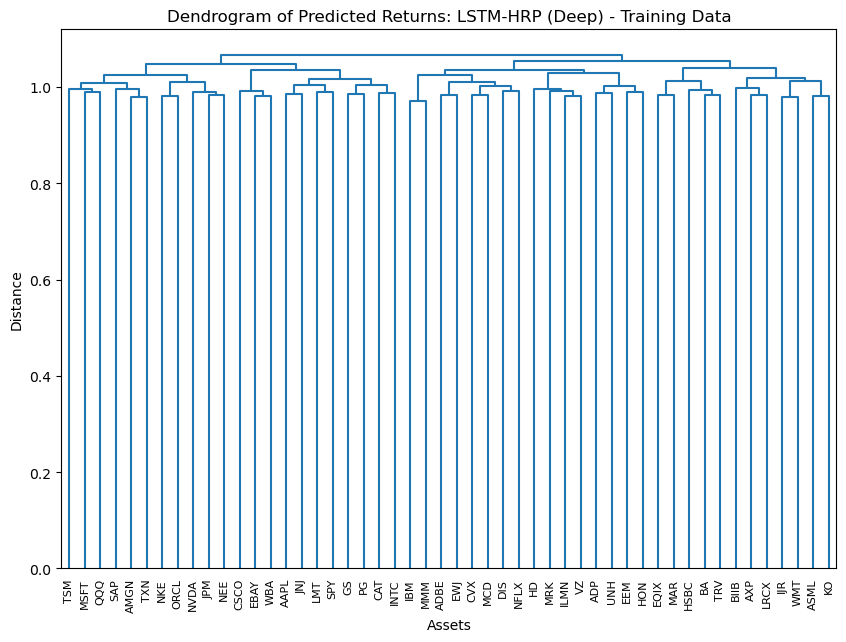

In [16]:
def plot_dendrogram(returns, title):
    plt.figure(figsize=(10, 7))
    corr = returns.corr()
    dist = correlDist(corr)
    link = linkage(dist, 'ward')
    dendrogram(link, labels=returns.columns)
    plt.title(title)
    plt.xlabel('Assets')
    plt.ylabel('Distance')
    plt.show()
    
# Dendrogram for training data
plot_dendrogram(predicted_returns_train, "Dendrogram of Predicted Returns: LSTM-HRP (Deep) - Training Data")

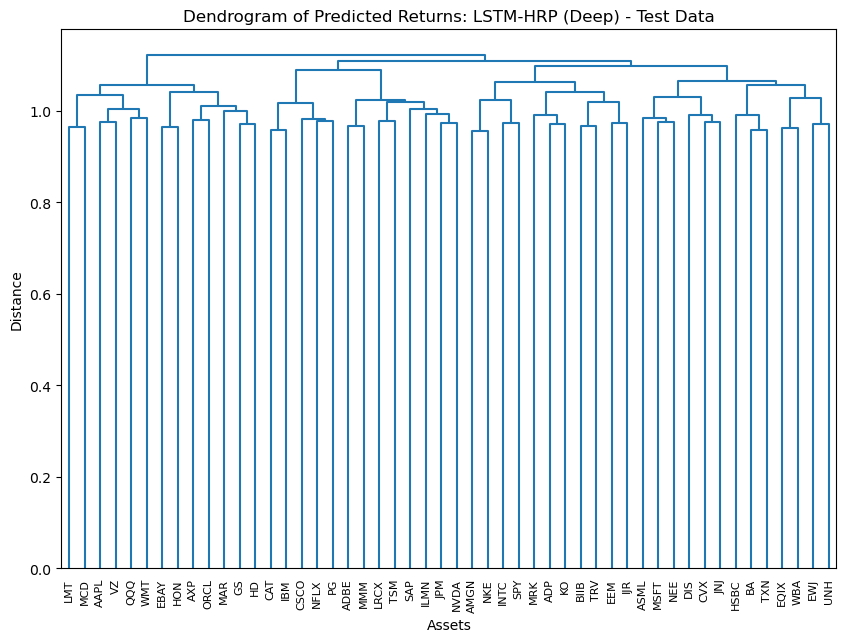

In [17]:
# Dendrogram for test data
plot_dendrogram(predicted_returns_test, "Dendrogram of Predicted Returns: LSTM-HRP (Deep) - Test Data")

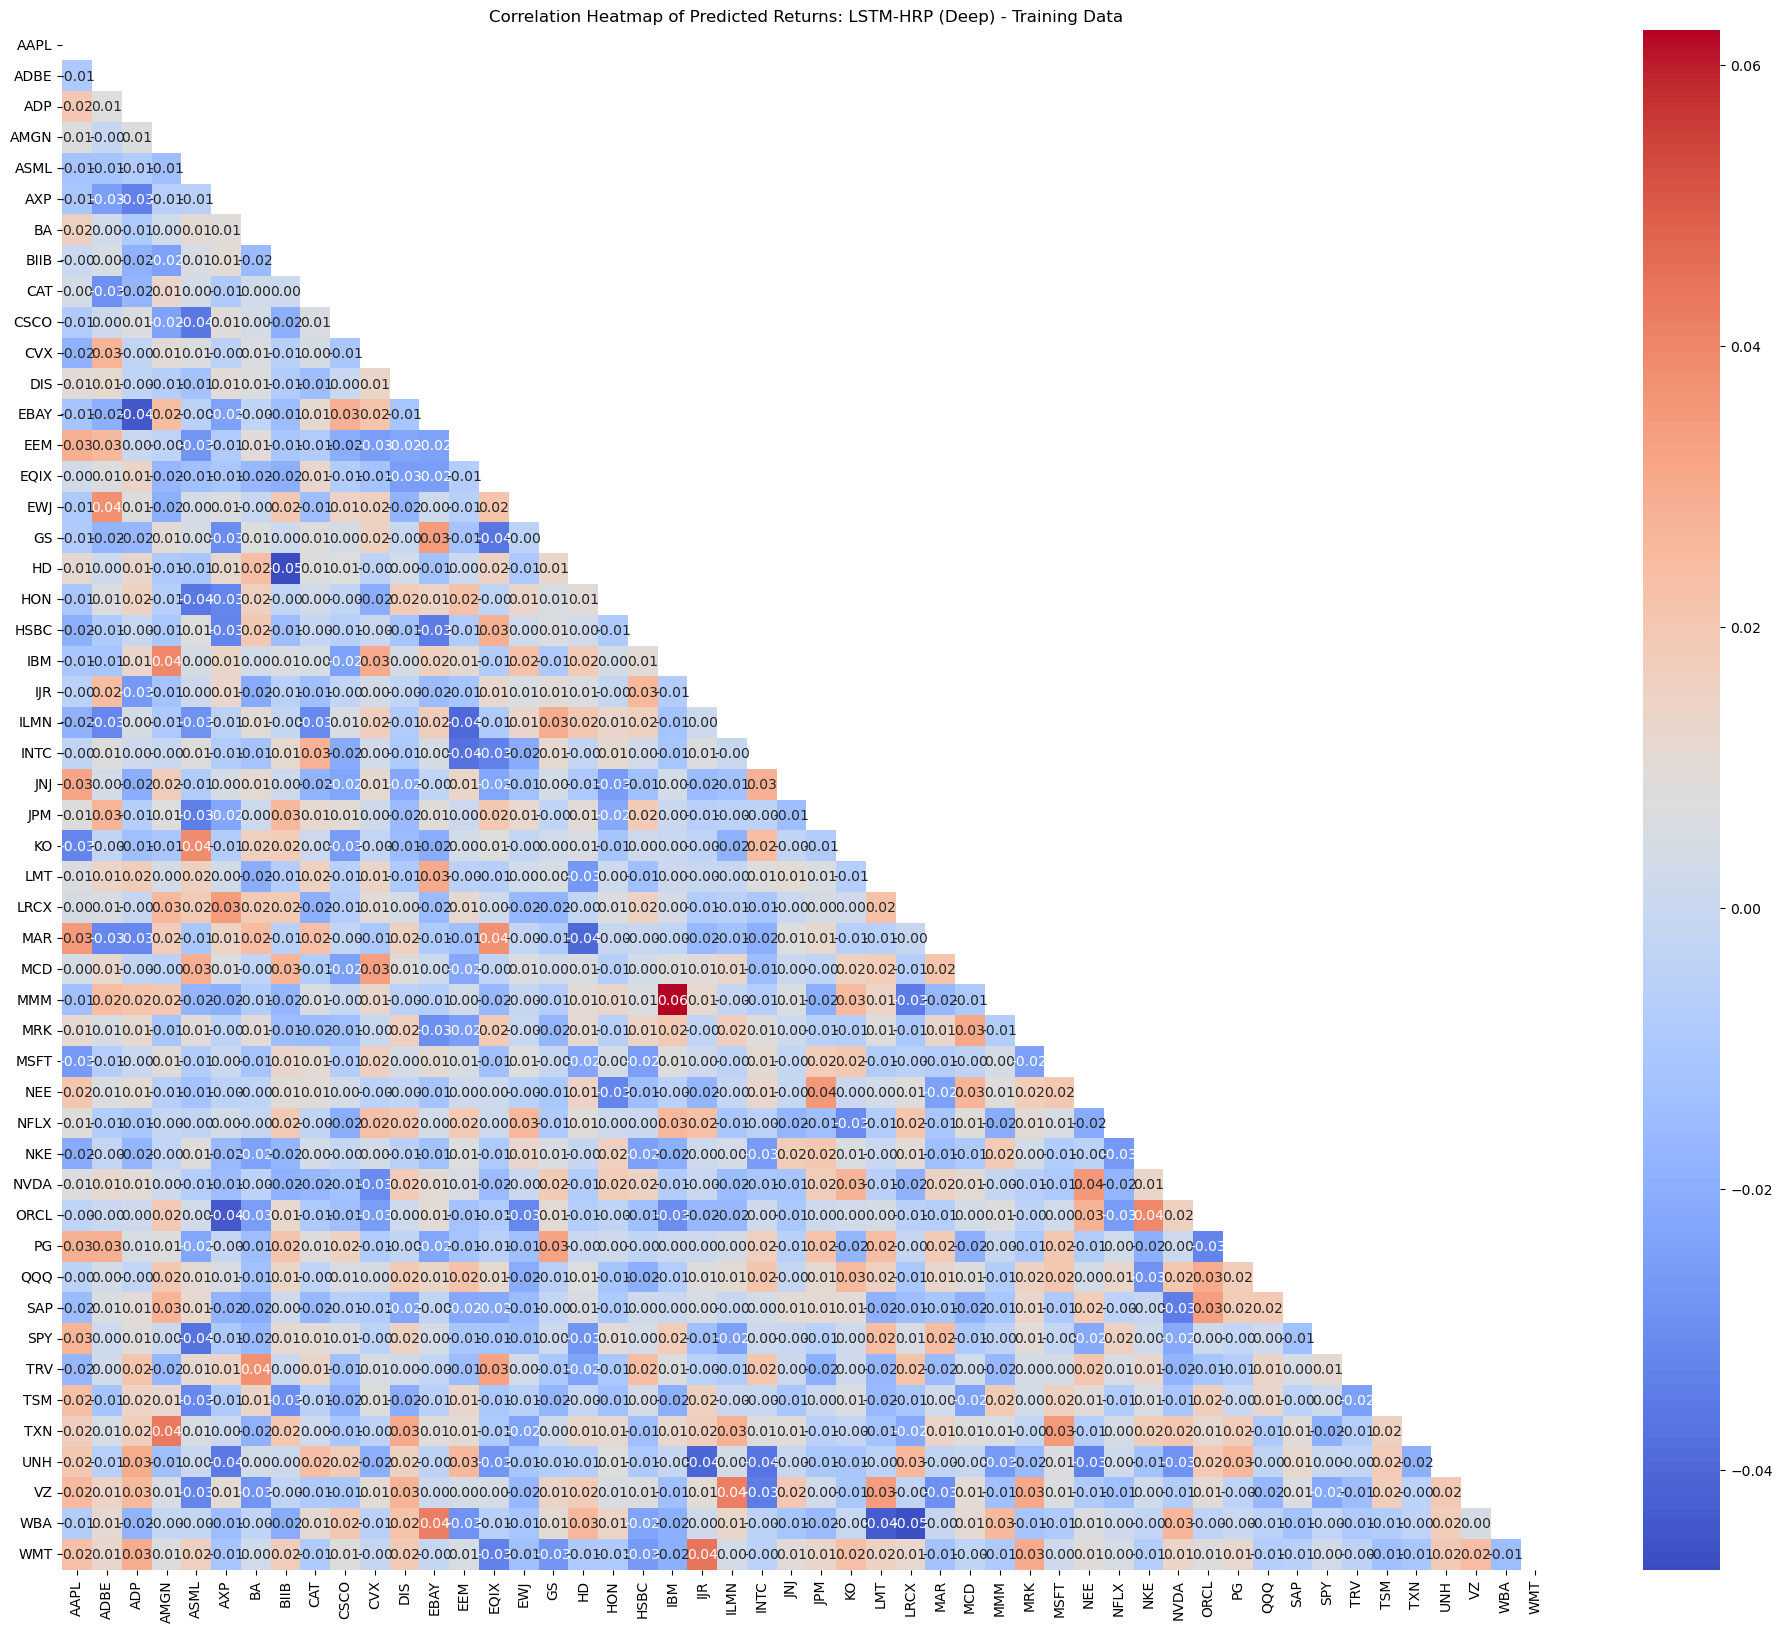

In [18]:
def plot_heatmap(returns, title):
    plt.figure(figsize=(24, 20))
    corr = returns.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title(title)
    plt.show()

# Heatmap for training data
plot_heatmap(predicted_returns_train, "Correlation Heatmap of Predicted Returns: LSTM-HRP (Deep) - Training Data")

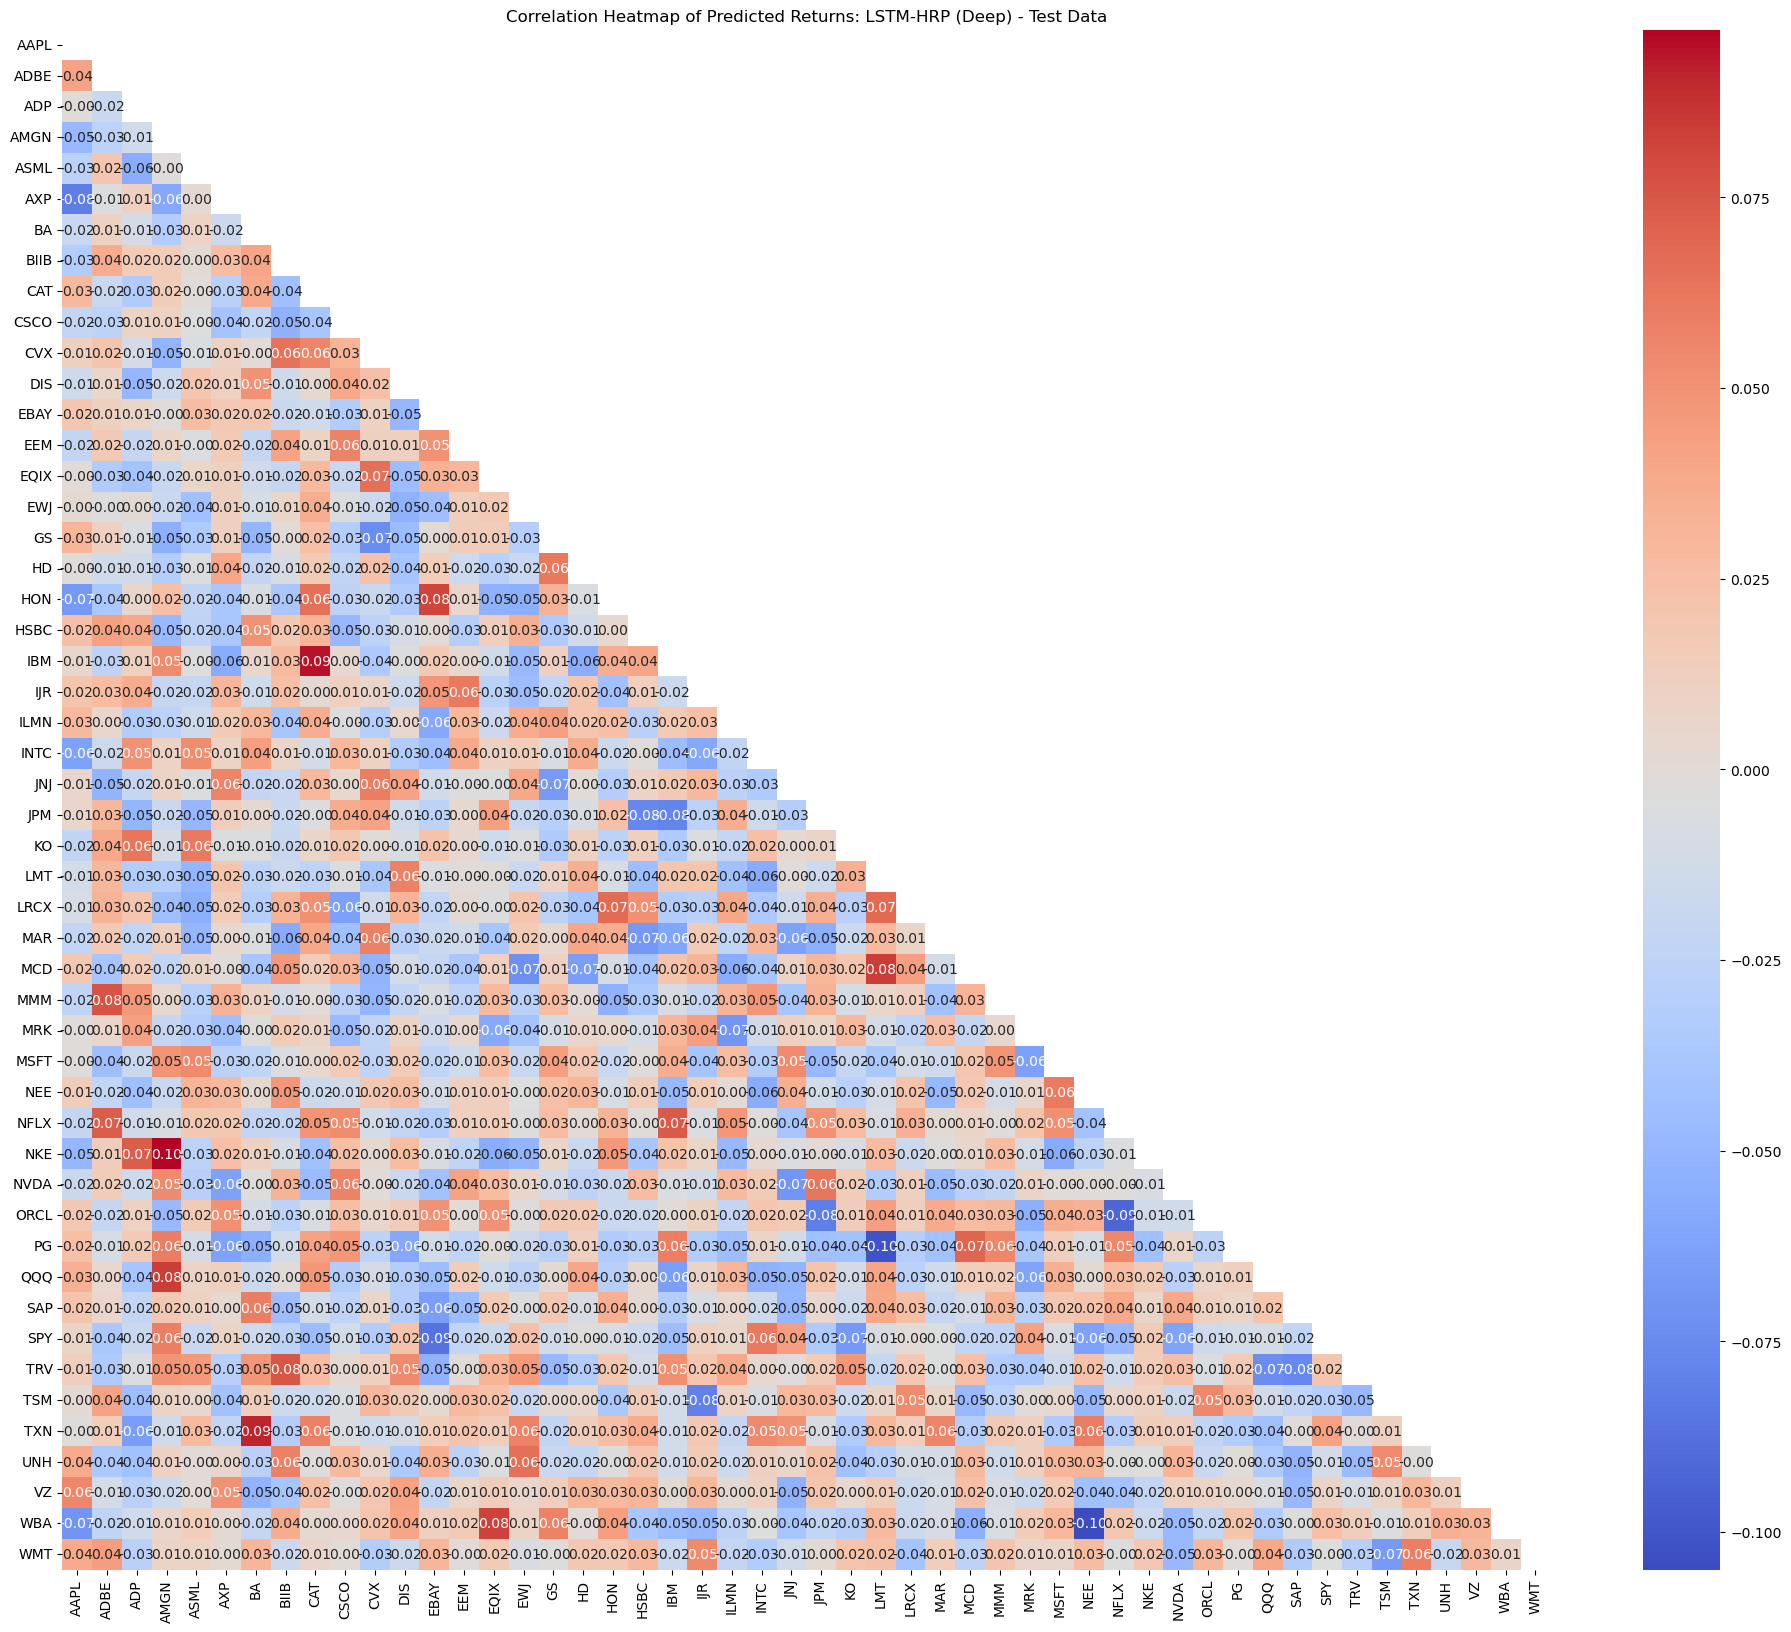

In [19]:
# Heatmap for test data
plot_heatmap(predicted_returns_test, "Correlation Heatmap of Predicted Returns: LSTM-HRP (Deep) - Test Data")

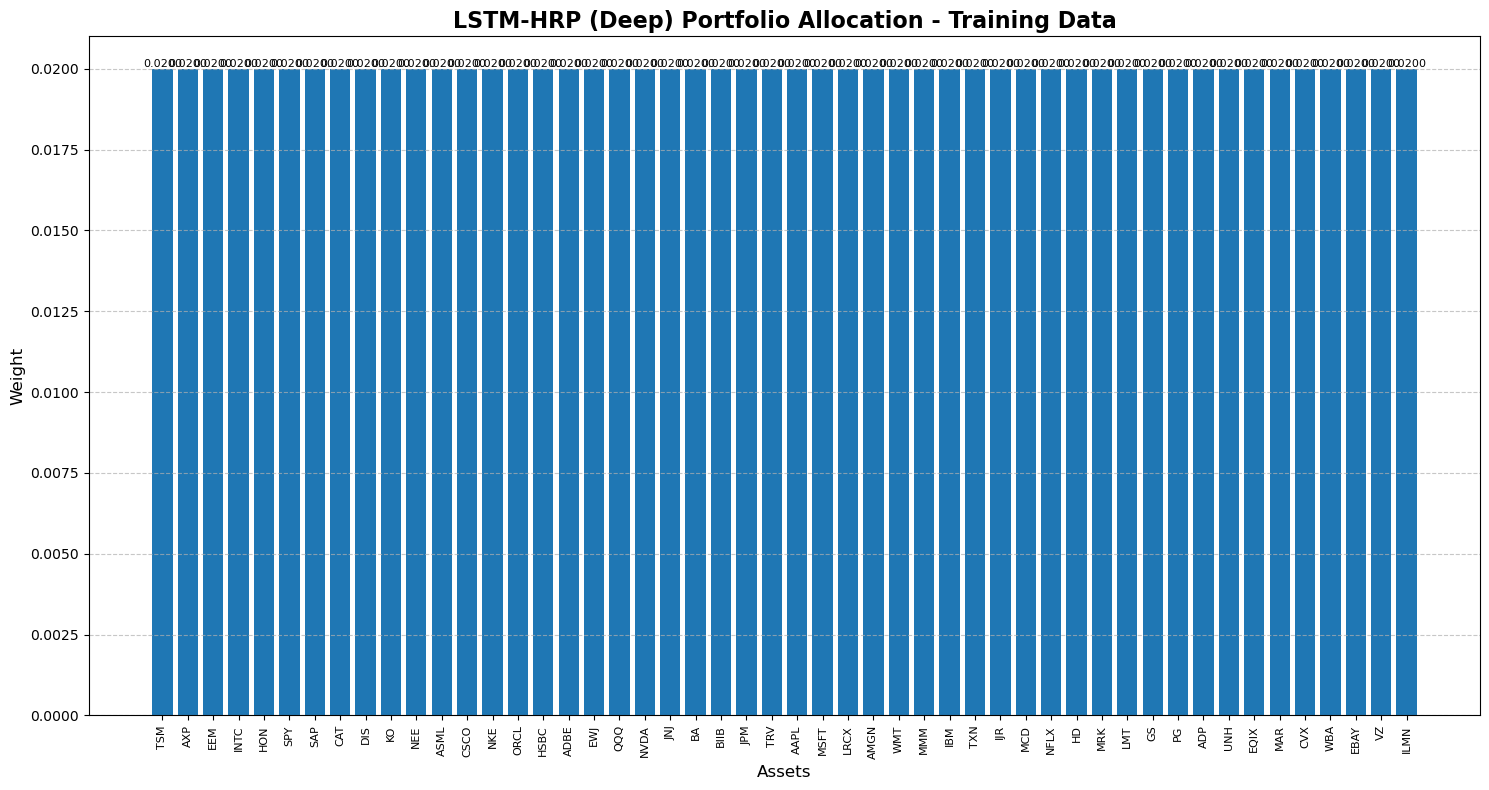

In [20]:
def plot_portfolio_allocation(portfolios, title, max_assets=50):
    # Ensure it's a series
    if isinstance(portfolios, pd.DataFrame):
        portfolios = portfolios.iloc[:, 0]  # Take the first column if it's a DataFrame
    
    # Sort and limit to top assets
    sorted_portfolio = portfolios.sort_values(ascending=False).head(max_assets)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create a bar plot using matplotlib 
    bars = ax.bar(range(len(sorted_portfolio)), sorted_portfolio.values)
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Assets', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_xticks(range(len(sorted_portfolio)))
    ax.set_xticklabels(sorted_portfolio.index, rotation=90, ha='center', fontsize=8)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)
    
    # Adjust layout and display gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot for training data
plot_portfolio_allocation(portfolios_train, "LSTM-HRP (Deep) Portfolio Allocation - Training Data")



In [21]:
sorted_portfolio_train = portfolios_train.sort_values(by="HRP", ascending=False).head(10)
print(sorted_portfolio_train)

       HRP
TSM   0.02
AXP   0.02
EEM   0.02
INTC  0.02
HON   0.02
SPY   0.02
SAP   0.02
CAT   0.02
DIS   0.02
KO    0.02


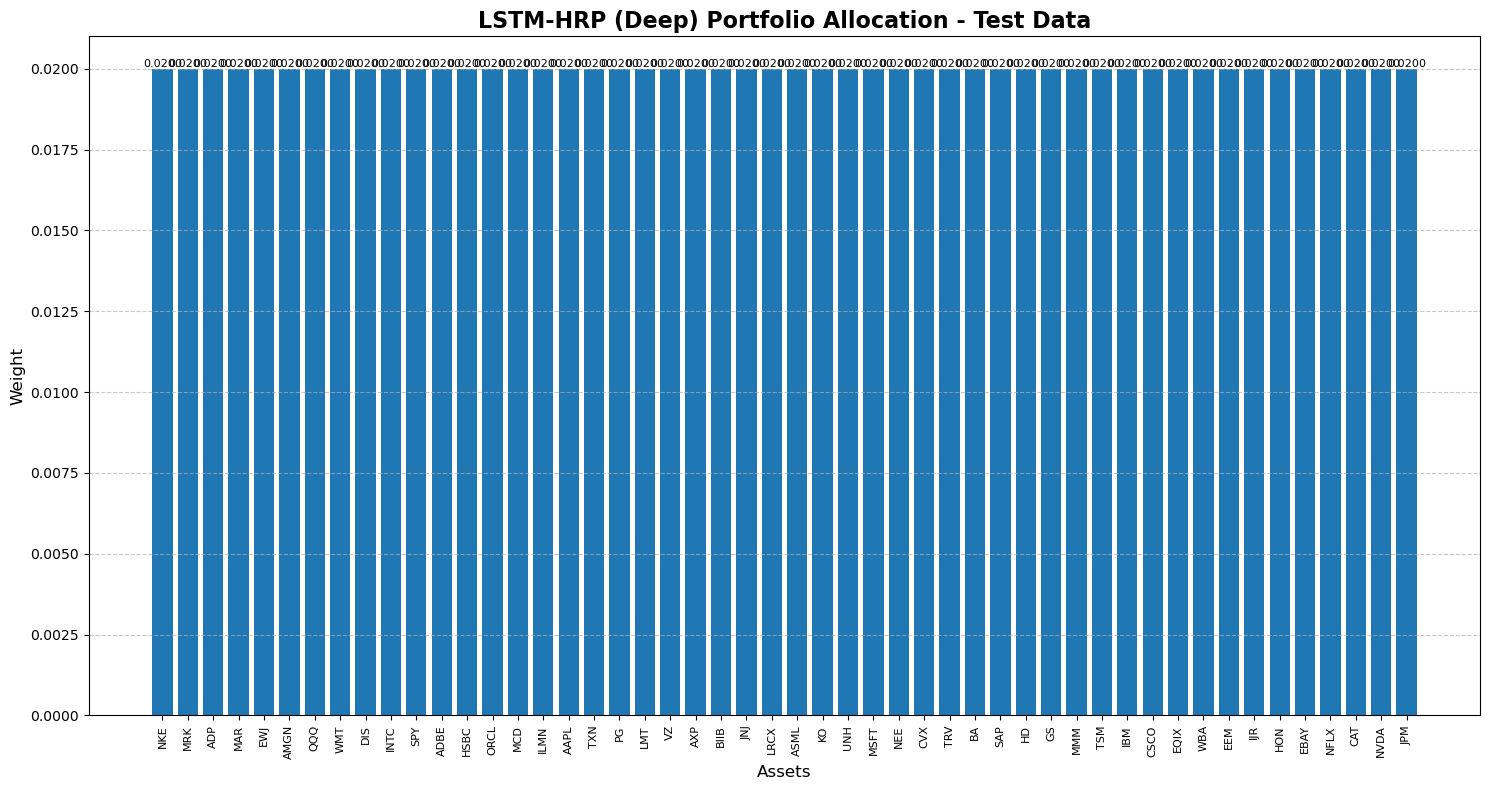

In [22]:
# Plot for test data
plot_portfolio_allocation(portfolios_test, "LSTM-HRP (Deep) Portfolio Allocation - Test Data")

In [23]:
sorted_portfolio_test = portfolios_test.sort_values(by="HRP", ascending=False).head(10)
print(sorted_portfolio_test)

       HRP
NKE   0.02
MRK   0.02
ADP   0.02
MAR   0.02
EWJ   0.02
AMGN  0.02
QQQ   0.02
WMT   0.02
DIS   0.02
INTC  0.02


In [24]:
# Metrics calculation
def calculate_metrics(returns, weights, risk_free_rate=0.02/252):
    # Calculate portfolio returns
    portfolio_returns = (returns * weights).sum(axis=1)
    
    # Basic metrics
    annual_return = portfolio_returns.mean() * 252
    annual_std = portfolio_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - risk_free_rate * 252) / annual_std
    
    # Sortino Ratio
    negative_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = negative_returns.std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate * 252) / downside_std if len(negative_returns) > 0 else np.nan
    
    # Maximum Drawdown
    cum_returns = (1 + portfolio_returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdowns = cum_returns/rolling_max - 1
    max_drawdown = drawdowns.min()
    
    # Calmar Ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    # Value at Risk (95% confidence)
    var_95 = np.percentile(portfolio_returns, 5)
    
    # Conditional Value at Risk
    cvar_95 = portfolio_returns[portfolio_returns <= var_95].mean()
    
    # Additional Statistics
    skewness = stats.skew(portfolio_returns)
    kurtosis = stats.kurtosis(portfolio_returns)
    hit_rate = len(portfolio_returns[portfolio_returns > 0]) / len(portfolio_returns)
    
    return pd.Series({
        'Annual Return': annual_return,
        'Annual Volatility': annual_std,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Value at Risk (95%)': var_95,
        'Conditional VaR (95%)': cvar_95,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Hit Rate': hit_rate
    })


In [25]:
# Original HRP performance (without LSTM)
def get_hrp_weights(returns):
    cov, corr = returns.cov(), returns.corr()
    return getHRP(cov, corr)

# Calculate original weights(without LSTM)
original_train_weights = get_hrp_weights(full_returns[:len(predicted_returns_train)])
original_test_weights = get_hrp_weights(full_returns[len(predicted_returns_train):])

In [26]:
# Calculate metrics for both strategies
print("\nLSTM-HRP (Deep) Performance Metrics:")
print("\nIn-sample metrics:")
lstm_in_sample_metrics = calculate_metrics(predicted_returns_train, portfolios_train.iloc[:, 0])
print(lstm_in_sample_metrics)

print("\nOut-of-sample metrics:")
lstm_out_of_sample_metrics = calculate_metrics(predicted_returns_test, portfolios_test.iloc[:, 0])
print(lstm_out_of_sample_metrics)

print("\nOriginal HRP Performance Metrics:")
print("\nIn-sample metrics:")
original_in_sample_metrics = calculate_metrics(full_returns[:len(predicted_returns_train)], original_train_weights)
print(original_in_sample_metrics)

print("\nOut-of-sample metrics:")
original_out_of_sample_metrics = calculate_metrics(full_returns[len(predicted_returns_train):], original_test_weights)
print(original_out_of_sample_metrics)


LSTM-HRP (Deep) Performance Metrics:

In-sample metrics:
Annual Return                0.142875
Annual Volatility            0.000009
Sharpe Ratio             13431.980988
Sortino Ratio                     NaN
Maximum Drawdown             0.000000
Calmar Ratio                      NaN
Value at Risk (95%)          0.000566
Conditional VaR (95%)        0.000566
Skewness                    -0.061286
Kurtosis                     0.041136
Hit Rate                     1.000000
dtype: float64

Out-of-sample metrics:
Annual Return                0.142867
Annual Volatility            0.000009
Sharpe Ratio             13173.213133
Sortino Ratio                     NaN
Maximum Drawdown             0.000000
Calmar Ratio                      NaN
Value at Risk (95%)          0.000566
Conditional VaR (95%)        0.000566
Skewness                    -0.088631
Kurtosis                     0.068099
Hit Rate                     1.000000
dtype: float64

Original HRP Performance Metrics:

In-sample metric

In [27]:
# Create comparison DataFrames
in_sample_comparison = pd.DataFrame({
    'LSTM-HRP (Deep)': lstm_in_sample_metrics,
    'Original-HRP': original_in_sample_metrics
})

out_sample_comparison = pd.DataFrame({
    'LSTM-HRP (Deep)': lstm_out_of_sample_metrics,
    'Original-HRP': original_out_of_sample_metrics
})

print("\nIn-Sample Comparison:")
print(in_sample_comparison)
print("\nOut-of-Sample Comparison:")
print(out_sample_comparison)

# Calculate improvements
print("\nMetric Improvements: LSTM-HRP (Deep) vs Original HRP:")
improvements = lstm_out_of_sample_metrics - original_out_of_sample_metrics
print(improvements)


In-Sample Comparison:
                       LSTM-HRP (Deep)  Original-HRP
Annual Return                 0.142875      0.121725
Annual Volatility             0.000009      0.159294
Sharpe Ratio              13431.980988      0.638602
Sortino Ratio                      NaN      0.811436
Maximum Drawdown              0.000000     -0.414925
Calmar Ratio                       NaN      0.293367
Value at Risk (95%)           0.000566     -0.015204
Conditional VaR (95%)         0.000566     -0.023914
Skewness                     -0.061286      0.169826
Kurtosis                      0.041136     12.653309
Hit Rate                      1.000000      0.550761

Out-of-Sample Comparison:
                       LSTM-HRP (Deep)  Original-HRP
Annual Return                 0.142867      0.094590
Annual Volatility             0.000009      0.191556
Sharpe Ratio              13173.213133      0.389388
Sortino Ratio                      NaN      0.485113
Maximum Drawdown              0.000000     -0.278


Rolling Metrics Visualization:


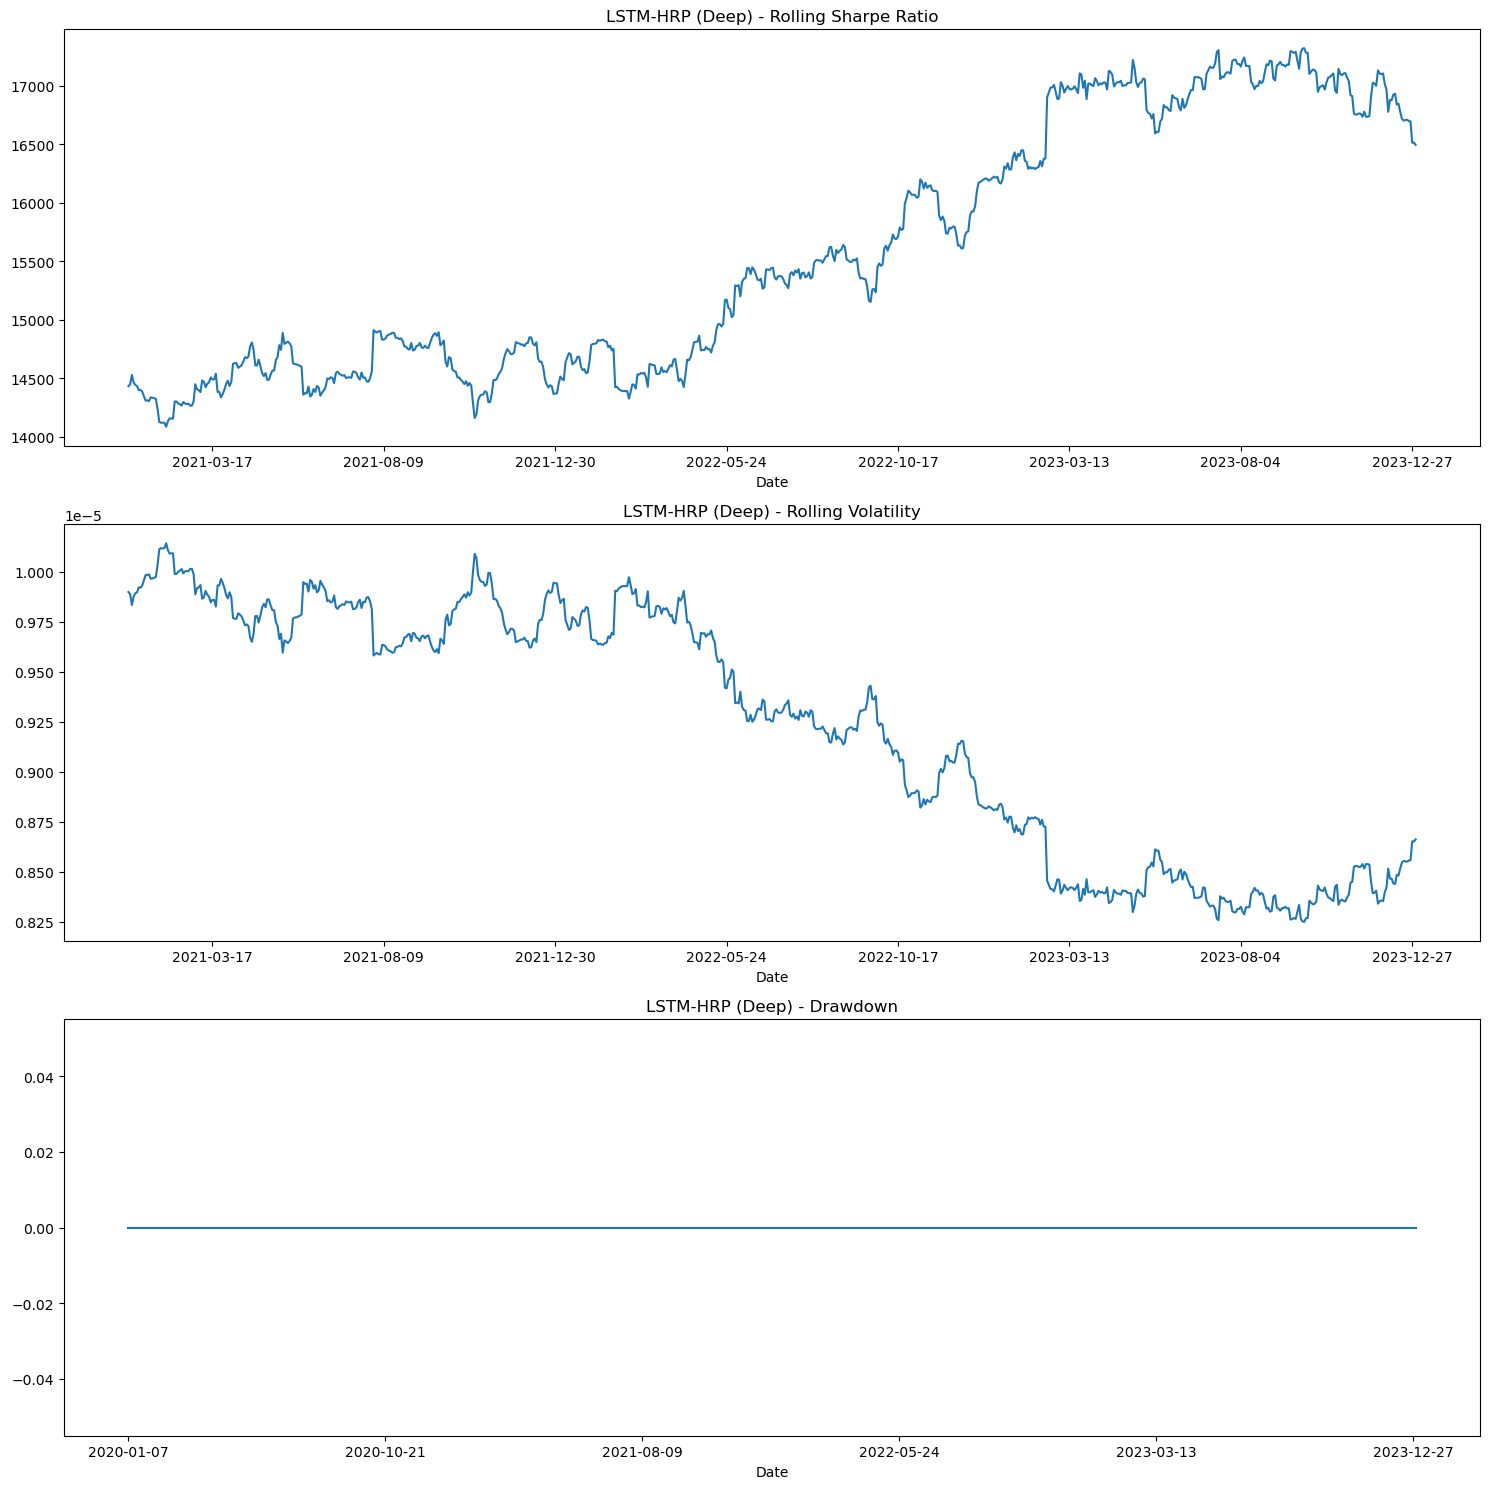

In [28]:
# Visualize rolling metrics
def plot_rolling_metrics(returns, weights, window=252, title=""):
    portfolio_returns = (returns * weights).sum(axis=1)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    # Rolling Sharpe Ratio
    rolling_ret = portfolio_returns.rolling(window=window).mean() * 252
    rolling_vol = portfolio_returns.rolling(window=window).std() * np.sqrt(252)
    rolling_sharpe = rolling_ret / rolling_vol
    rolling_sharpe.plot(ax=axes[0], title=f'{title} - Rolling Sharpe Ratio')
    
    # Rolling Volatility
    rolling_vol.plot(ax=axes[1], title=f'{title} - Rolling Volatility')
    
    # Drawdown
    cum_returns = (1 + portfolio_returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdowns = cum_returns/rolling_max - 1
    drawdowns.plot(ax=axes[2], title=f'{title} - Drawdown')
    
    plt.tight_layout()
    plt.show()

# Plot rolling metrics for both strategies
print("\nRolling Metrics Visualization:")
plot_rolling_metrics(predicted_returns_test, portfolios_test.iloc[:, 0], title="LSTM-HRP (Deep)")

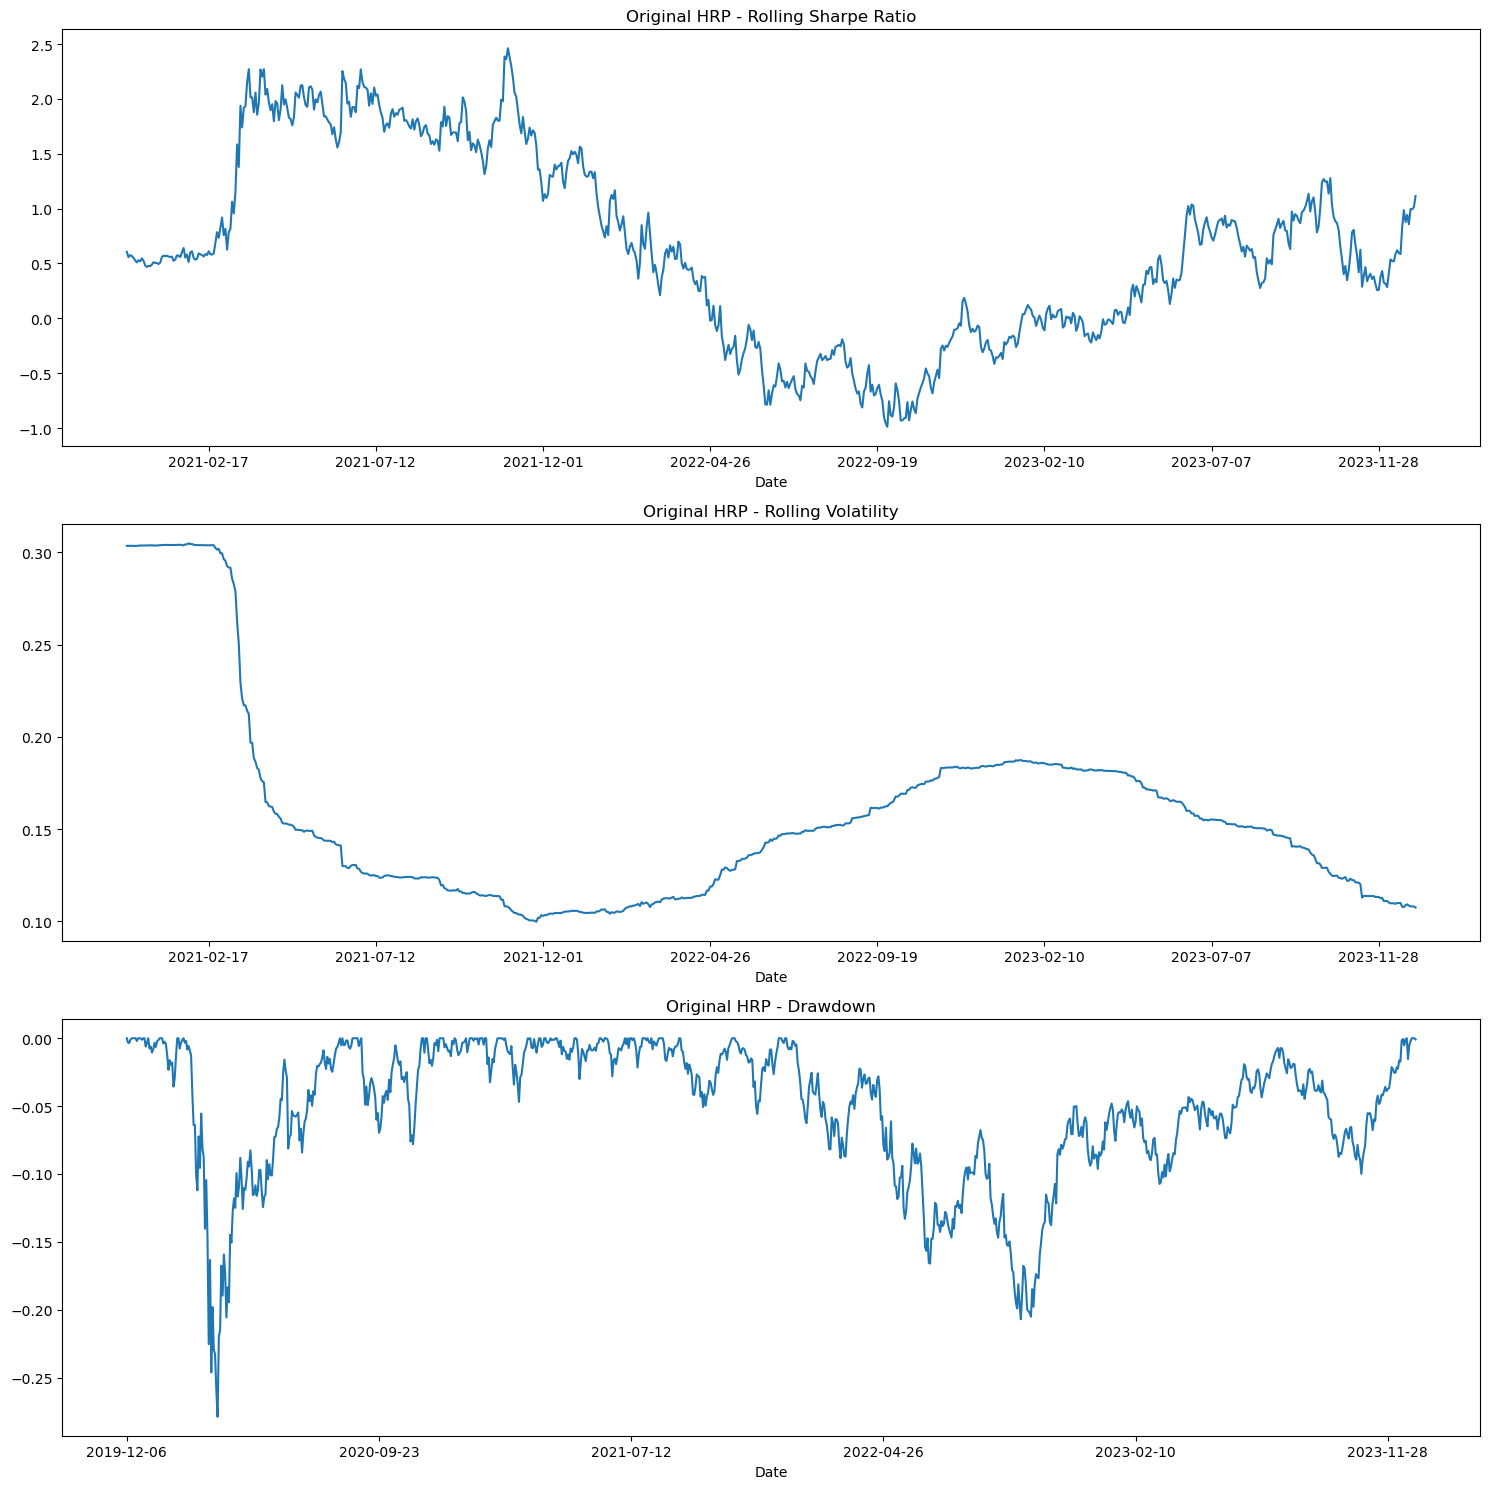

In [29]:
plot_rolling_metrics(full_returns[len(predicted_returns_train):], original_test_weights, title="Original HRP")

#### Code References:

1) ADFT Lab Notebooks
2) https://www.kaggle.com/code/imoore/intro-to-exploratory-data-analysis-eda-in-python
3) https://www.kaggle.com/code/bhavyajoshi02022000/outlier-z-score-iqr
4) https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/5-Hierarchical-Risk-Parity.ipynb
5) https://github.com/TheRockXu/Hierarchical-Risk-Parity/blob/master/Hierarchical%20Clustering.ipynb
6) https://github.com/d-jiao/LSTM-For-Stock-Market-Prediction/blob/master/3_LSTM_Model.ipynb
7) https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm#6.-Predicting-the-closing-price-stock-price-of-APPLE-inc
8) https://www.kaggle.com/code/malingarajapaksha/stock-prediction-lstm#Modeling
9) https://www.kaggle.com/code/fredblair/transformers-for-stocks#Build-the-model
10) https://www.kaggle.com/code/selcukcan/nlp-9d-lstm-vs-transformers-for-stock-prediction#3.-Implementing-a-Transformer
